In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
from cycler import cycler
import os
os.chdir('/Users/cd8607/Documents/Lammps_MD')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)

global colors
colorblind_palette = plt.cm.tab10.colors

# Selecting the first four colors from the colorblind-friendly palette
colors = colorblind_palette[:6]

new_pot = np.loadtxt('new.txt')
jus_beck = np.loadtxt('beck.txt')
dft_data_img = np.loadtxt('dft_yang_new.txt')
dft_data = []

for v, h, he, img, ef, rvol in dft_data_img:
    if img == 0:
        dft_data.append([v, h, he, ef, rvol])
dft_data = np.array(dft_data)
# dft_data = np.vstack([[0, 0, 0, 0, 0], dft_data])

print(new_pot)
# print(new_pot - jus_beck)

[[ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          1.          6.73423824  0.49508626]
 [ 0.          0.          2.         12.5801334   0.82496129]
 ...
 [ 2.          9.          7.         24.84818532  2.89212002]
 [ 2.          9.          8.         28.87782863  3.22914864]
 [ 2.          9.          9.         31.47625834  3.53313051]]


In [2]:
x = np.arange(3)
y = np.arange(10)
z = np.arange(10)

xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')

eam_xyz =  np.column_stack((xx.ravel(), yy.ravel(), zz.ravel())).reshape(-1, 3)


In [3]:
def create_df(xyz, ef, rvol):

    key = {'vac':0, 'h':1, 'he':2, 'ef':3, 'rvol':4}

    data = np.column_stack((xyz[:,0].flatten(),
                            xyz[:,1].flatten(),
                            xyz[:,2].flatten(),
                            ef.flatten(),
                            rvol.flatten()))  
    
    sorted_indices = np.lexsort((data[:, 2], data[:, 1], data[:, 0]))

    data = data[sorted_indices]
    
    return data, key

In [4]:
### LOAD YOUR DATA HERE - currently it can do 2 potentials at a time with DFT ###

# Ensure you are in the correct directory
os.chdir('Numpy_Files/Point_Defects')

# I have seperate np files for everything

# xyz is the configuration: n_vac, n_h, n_he (in that order)
eam_xyz = np.load('xyz_new.npy')

eam_ef = np.load('ef_new.npy')

eam_rvol = np.load('rvol_new.npy')

eam_data, key = create_df(eam_xyz, eam_ef, eam_rvol)
eam_data = new_pot

bonny_xyz = np.column_stack((xx.ravel(), yy.ravel(), zz.ravel())).reshape(-1, 3)
bonny_ef = np.load('ef_bonny.npy')
bonny_rvol = np.load('rvol_bonny.npy')

bonny_data, key = create_df(bonny_xyz, bonny_ef, bonny_rvol)

bonny_data = bonny_data[ np.bitwise_not((bonny_data[:,0] == 0) & (bonny_data[:,1] == 0) & (bonny_data[:,0] == 7))]

bonny_data = bonny_data[ np.bitwise_not((bonny_data[:,0] == 0) & (bonny_data[:,1] == 0) & (bonny_data[:,0] == 8))]
bonny_data = np.loadtxt('../../bonny_data.txt')

### END LOAD #

dft_xyz = np.array(pd.read_csv('dft_xyz.csv'))
dft_ef =  np.array(pd.read_csv('dft_ef.csv'))
dft_rvol =  np.array(pd.read_csv('dft_rvol.csv'))

# dft_data, key = create_df(dft_xyz, dft_ef, dft_rvol)

# dft_data = np.vstack([[0, 0, 0, 0, 0], dft_data])

# print(dft_data)

In [5]:
def find_self_binding(data, key, slct, not_slct):


    int_he_idx = (data[:, key['vac']] == 0) & (data[:, key[not_slct]] == 0) & (data[:, key[slct]] == 1)
    
    int_he = data[int_he_idx,key['ef']]

    plt_dict = {}

    for vac in range(3):

        plt_dict['vac_%d' % vac] = {}

        idx = np.bitwise_and(data[:,key['vac']]==vac, data[:,key[not_slct]]==0)

        atom = data[idx,key[slct]]

        ef = data[idx,key['ef']]

        rvol = data[idx,key['rvol']]

        nan_ef = np.where(np.isnan(ef) == False)[0]
        
        x = atom[nan_ef]

        y = ef[nan_ef]
        
        sort_idx = np.argsort(x)

        x = x[sort_idx]
        y = y[sort_idx]
        
        if vac == 0:
            x_plt = np.arange(1, len(x)-1)

            y_plt = (int_he - np.diff(y))[1:]
        else:
            x_plt = np.arange(len(x) - 1)

            y_plt = (int_he - np.diff(y))

        plt_dict['vac_%d' % vac]['x_bind'] = x_plt

        plt_dict['vac_%d' % vac]['y_bind'] = y_plt

        nan_ef = np.where(np.isnan(rvol) == False)[0]

        x = atom[nan_ef]

        y = rvol[nan_ef]

        sort_idx = np.argsort(x)

        x = x[sort_idx]
        y = y[sort_idx]

        plt_dict['vac_%d' % vac]['x_rvol'] = x

        plt_dict['vac_%d' % vac]['y_rvol'] = y

    return plt_dict

In [6]:
def plot_data_binding(plt_dict, title, xtitle):

    N_plts = len(plt_dict['dft'].keys())

    fig, axs = plt.subplots(1, N_plts, sharex=True, sharey=True, figsize = (15,6))
    
    plt.style.use('tableau-colorblind10')

    for i, vac_key in enumerate(plt_dict['dft'].keys()):
        # Get data for the current vac_key
        x_values = [plt_dict[key][vac_key]['x_bind'] for key in plt_dict.keys()]
        y_values = [plt_dict[key][vac_key]['y_bind'] for key in plt_dict.keys()]
        labels = plt_dict.keys()

        # Plot data for each label
        x_max = []
        y_max = []
        k = 0
        for x, y, label in zip(x_values, y_values, labels):

            axs[i].plot(x, y, label=label, linestyle=':', marker='o',color=colors[k])
            x_max.append(x.max())
            y_max.append(y.max())
            k += 1
            
        axs[i].set_ylim(0, np.max(y_max)+0.5)
        
        axs[i].legend()
        axs[i].set_title(vac_key, fontsize=14)

    fig.suptitle(title, y=0.975, fontsize=16)
    fig.text(0.5, 0.04,xtitle, ha='center', fontsize=14)
    fig.text(0.075, 0.5, 'Binding (Trapping) Energy/ eV', va='center', rotation='vertical', fontsize=14)

    
    plt.show()

def plot_data_rvol(plt_dict, title, xtitle):

    N_plts = len(plt_dict['dft'].keys())

    fig, axs = plt.subplots(1, N_plts, sharex=True, sharey=True, figsize = (15,6))
    
    plt.style.use('tableau-colorblind10')

    for i, vac_key in enumerate(plt_dict['dft'].keys()):
        # Get data for the current vac_key
        x_values = [plt_dict[key][vac_key]['x_rvol'] for key in plt_dict.keys()]
        y_values = [plt_dict[key][vac_key]['y_rvol'] for key in plt_dict.keys()]
        labels = plt_dict.keys()

        # Plot data for each label
        x_max = []
        y_max = []
        k = 0
        for x, y, label in zip(x_values, y_values, labels):

            if len(y) > 0:
                axs[i].plot(x, y, label=label, linestyle=':', marker='o', color=colors[k])
                x_max.append(x.max())
                y_max.append(y.max())
            k += 1

        # axs[i].set_ylim(0, np.max(y_max)+0.5)
        
        axs[i].legend()
        axs[i].set_title(vac_key, fontsize=14)

    fig.suptitle(title, y=0.975, fontsize=16)
    fig.text(0.5, 0.04,xtitle, ha='center', fontsize=14)
    fig.text(0.075, 0.5, 'Relaxation Volume/ Lattice Volume', va='center', rotation='vertical', fontsize=14)

    
    plt.show()


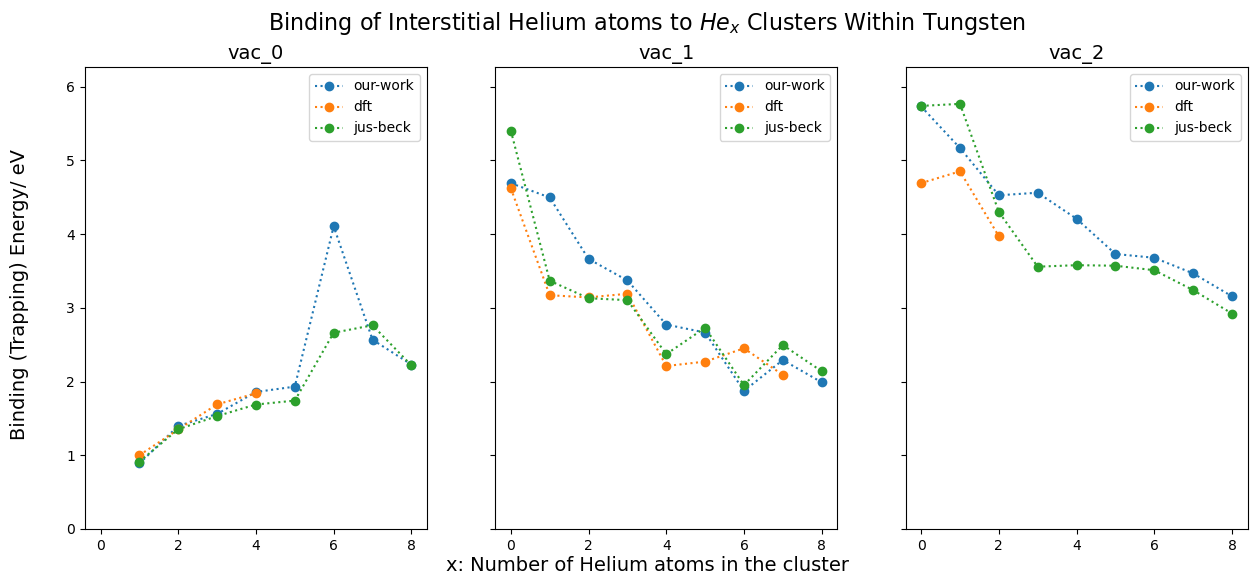

[-0.3187 -0.23   -0.06    0.14    0.38    0.71    1.09  ]
{'x_bind': array([1, 2, 3, 4, 5, 6, 7, 8]), 'y_bind': array([0.88834307, 1.39788694, 1.56055478, 1.85803754, 1.93071963,
       4.1051303 , 2.56636069, 2.230072  ]), 'x_rvol': array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), 'y_rvol': array([0.        , 0.49508626, 0.82496129, 1.11154467, 1.6125584 ,
       1.8439223 , 2.40866285, 2.88296769, 3.39666068, 3.75195153])}


In [7]:
eam_he_self = find_self_binding(eam_data, key, 'he', 'h')
dft_he_self = find_self_binding(dft_data, key, 'he', 'h')
bonny_he_self = find_self_binding(bonny_data, key, 'he', 'h')
new_he_self = find_self_binding(new_pot, key, 'he', 'h')
jus_he_self = find_self_binding(jus_beck, key, 'he', 'h')
# Convert each dictionary into a DataFrame
he_self = pd.DataFrame({'our-work':eam_he_self, 'dft':dft_he_self, 'jus-beck': jus_he_self})

plot_data_binding(he_self,'Binding of Interstitial Helium atoms to $He_x$ Clusters Within Tungsten', 'x: Number of Helium atoms in the cluster')

print(dft_he_self['vac_1']['y_rvol'])

print(eam_he_self['vac_0'])


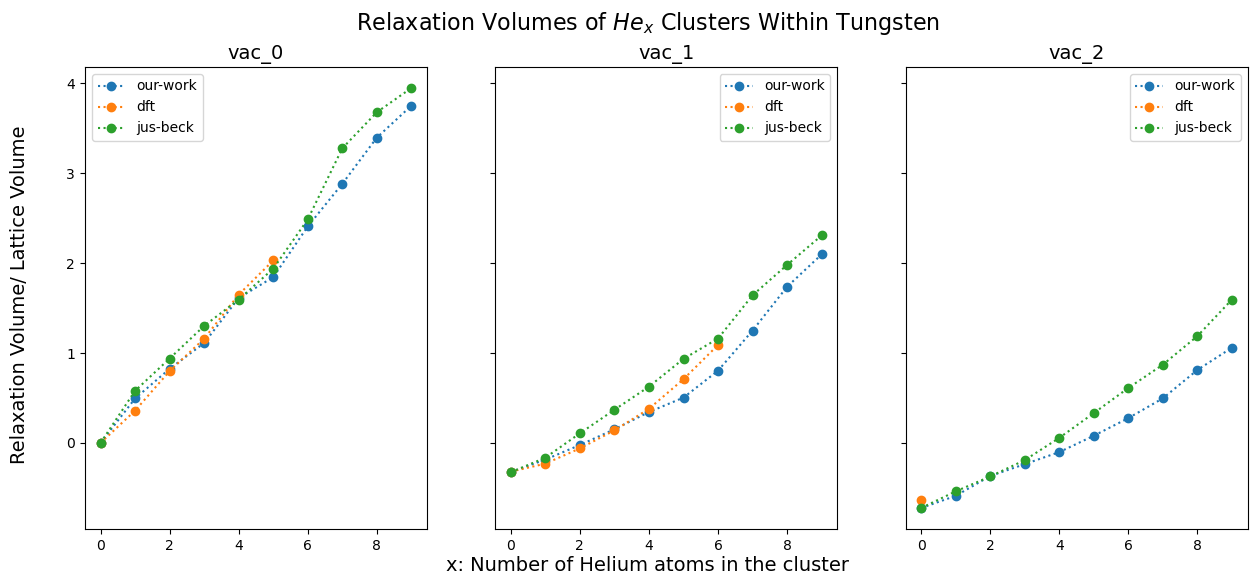

In [8]:
plot_data_rvol(he_self,'Relaxation Volumes of $He_x$ Clusters Within Tungsten', 'x: Number of Helium atoms in the cluster')


In [9]:
def find_h_he_binding(data, key, n_h):


    int_he_idx = (data[:, key['vac']] == 0) & (data[:, key['he']] == 0) & (data[:, key['h']] == 1)
    
    int_he = data[int_he_idx,key['ef']]

    plt_dict = {}

    for vac in range(3):

        plt_dict['vac_%d' % vac] = {}

        idx_1 = np.bitwise_and(data[:,key['vac']]==vac, data[:,key['h']]==n_h)

        idx_2 = np.bitwise_and(data[:,key['vac']]==vac, data[:,key['h']]==n_h+1)


        ef1 = data[idx_1,key['ef']]

        ef2 = data[idx_2,key['ef']]

        max_length = max(len(ef1), len(ef2))
        
        # Pad the first array with np.nan
        ef1 = np.pad(ef1, (0, max_length - len(ef1)), constant_values=np.nan)
        
        # Pad the second array with np.nan
        ef2 = np.pad(ef2, (0, max_length - len(ef2)), constant_values=np.nan)
                
        atom = data[idx_1,key['he']]

        rvol = data[idx_1,key['rvol']]

        nan_ef = np.where(np.bitwise_and(np.isnan(ef1) == False,np.isnan(ef2) == False))[0]
        
        x = atom[nan_ef]
        
        y1 = ef1[nan_ef]

        y2 = ef2[nan_ef]

        sort_idx = np.argsort(x)

        x = x[sort_idx]
        y1 = y1[sort_idx]
        y2 = y2[sort_idx]

        x_plt = np.arange(len(x))

        y_plt = int_he - y2 + y1

        if vac == 0:
            plt_dict['vac_%d' % vac]['x_bind'] = x_plt[1:]

            plt_dict['vac_%d' % vac]['y_bind'] = y_plt[1:]
        else:
            plt_dict['vac_%d' % vac]['x_bind'] = x_plt

            plt_dict['vac_%d' % vac]['y_bind'] = y_plt

        nan_ef = np.where(np.isnan(rvol) == False)[0]

        x = atom[nan_ef]

        y = rvol[nan_ef]

        sort_idx = np.argsort(x)

        x = x[sort_idx]
        y = y[sort_idx]

        plt_dict['vac_%d' % vac]['x_rvol'] = x

        plt_dict['vac_%d' % vac]['y_rvol'] = y

    return plt_dict

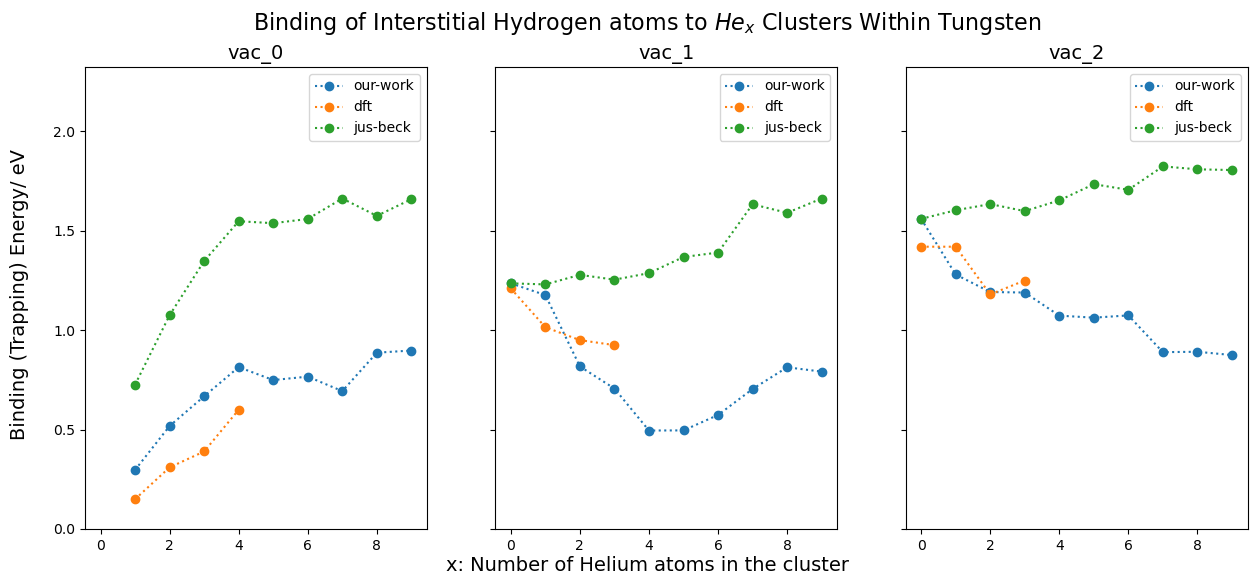

In [10]:
eam_he_self = find_h_he_binding(eam_data, key, 0)
dft_he_self = find_h_he_binding(dft_data, key, 0)
bonny_he_self = find_h_he_binding(bonny_data, key, 0)
new_he_self = find_h_he_binding(new_pot, key, 0)
jus_he_self = find_h_he_binding(jus_beck, key, 0)

# Convert each dictionary into a DataFrame
h_he_self = pd.DataFrame({'our-work':eam_he_self, 'dft':dft_he_self, 'jus-beck':jus_he_self})#, 'jus-beck':jus_he_self})
plot_data_binding(h_he_self,'Binding of Interstitial Hydrogen atoms to $He_x$ Clusters Within Tungsten', 'x: Number of Helium atoms in the cluster')

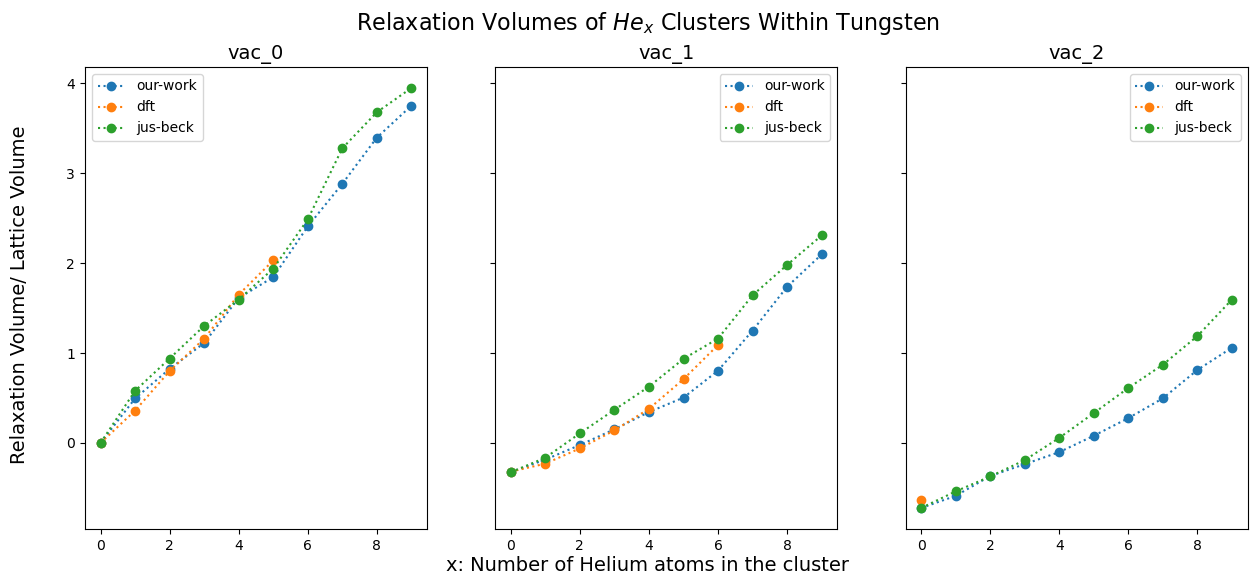

In [11]:
plot_data_rvol(h_he_self,'Relaxation Volumes of $He_x$ Clusters Within Tungsten', 'x: Number of Helium atoms in the cluster')

{'vac_0': {'x_bind': array([1, 2, 3, 4]), 'y_bind': array([0.29, 0.35, 0.53, 0.4 ]), 'x_rvol': array([0., 1., 2., 3., 4.]), 'y_rvol': array([0.1849, 0.5868, 1.0449, 1.5088, 1.9557])}, 'vac_1': {'x_bind': array([0, 1, 2, 3]), 'y_bind': array([1.65, 0.95, 0.92, 0.81]), 'x_rvol': array([0., 1., 2., 3.]), 'y_rvol': array([-0.2706, -0.1116,  0.0872,  0.3711])}, 'vac_2': {'x_bind': array([0, 1, 2, 3]), 'y_bind': array([1.9 , 1.45, 1.15, 1.16]), 'x_rvol': array([1., 2., 3.]), 'y_rvol': array([-0.4291, -0.2794, -0.0655])}}


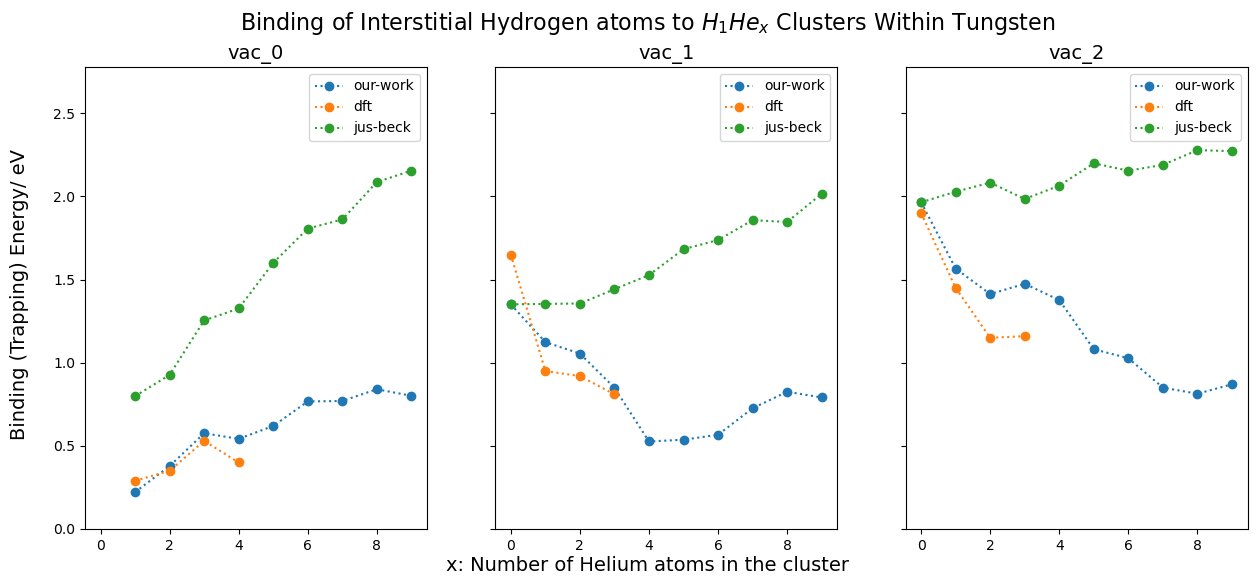

In [12]:
eam_he_self = find_h_he_binding(eam_data, key, 1)
dft_he_self = find_h_he_binding(dft_data, key, 1)
bonny_he_self = find_h_he_binding(jus_beck, key, 1)
new_he_self = find_h_he_binding(new_pot, key,  1)
print(dft_he_self)
# Convert each dictionary into a DataFrame
h_h1he_self = pd.DataFrame({'our-work':eam_he_self, 'dft':dft_he_self, 'jus-beck':bonny_he_self})
# Convert each dictionary into a DataFrame
plot_data_binding(h_h1he_self,'Binding of Interstitial Hydrogen atoms to $H_1He_x$ Clusters Within Tungsten', 'x: Number of Helium atoms in the cluster')

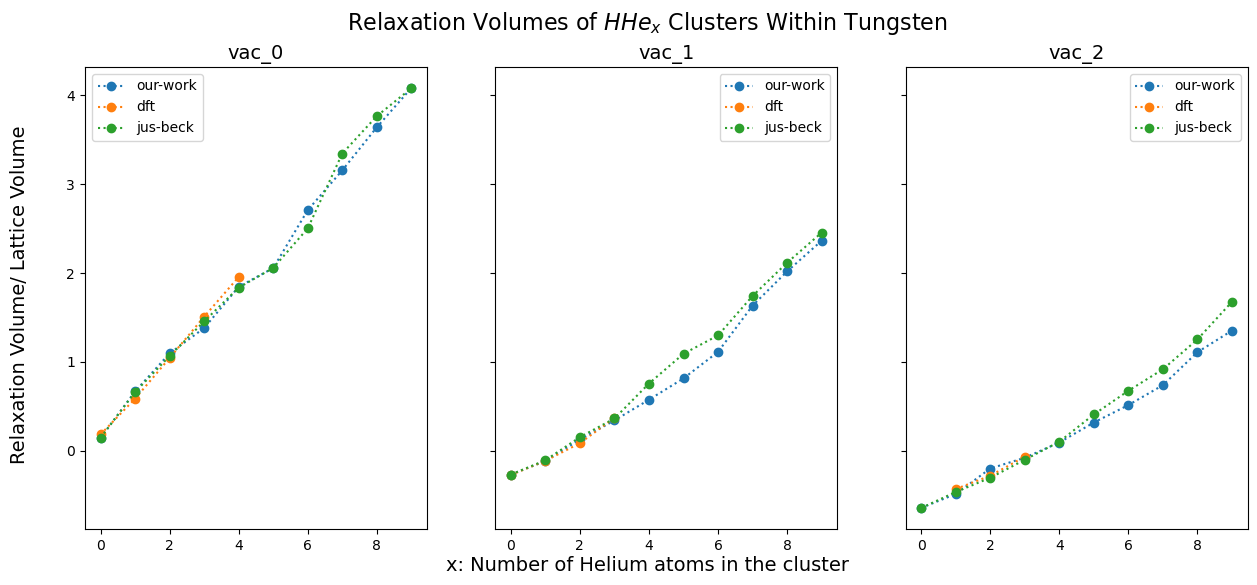

In [13]:
plot_data_rvol(h_h1he_self,'Relaxation Volumes of $HHe_x$ Clusters Within Tungsten', 'x: Number of Helium atoms in the cluster')

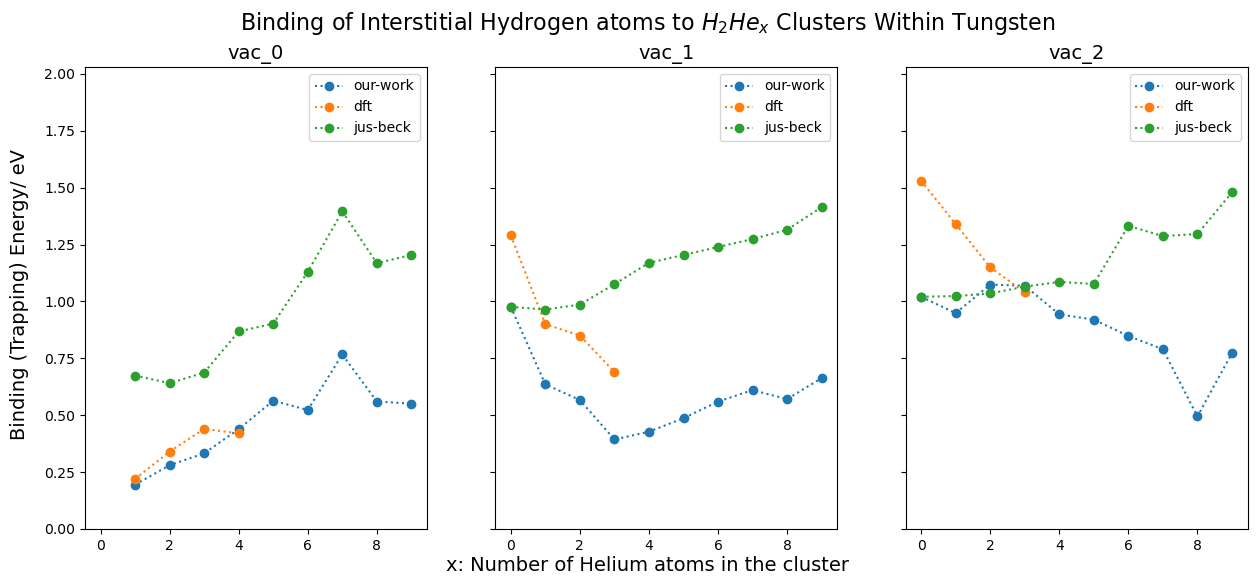

In [14]:
eam_he_self = find_h_he_binding(eam_data, key, 2)
dft_he_self = find_h_he_binding(dft_data, key, 2)
bonny_he_self = find_h_he_binding(jus_beck, key, 2)
new_he_self = find_h_he_binding(new_pot, key,  2)

# Convert each dictionary into a DataFrame
h_h2he_self = pd.DataFrame({'our-work':eam_he_self, 'dft':dft_he_self, 'jus-beck':bonny_he_self})

plot_data_binding(h_h2he_self,'Binding of Interstitial Hydrogen atoms to $H_2He_x$ Clusters Within Tungsten', 'x: Number of Helium atoms in the cluster')

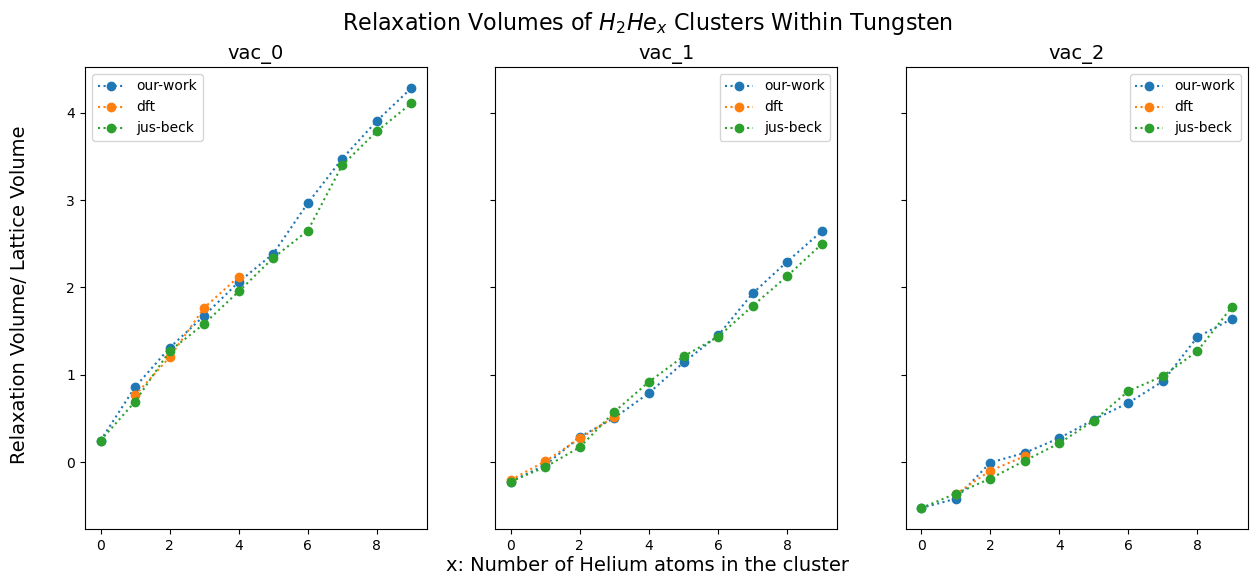

In [15]:
plot_data_rvol(h_h2he_self,'Relaxation Volumes of $H_2He_x$ Clusters Within Tungsten', 'x: Number of Helium atoms in the cluster')

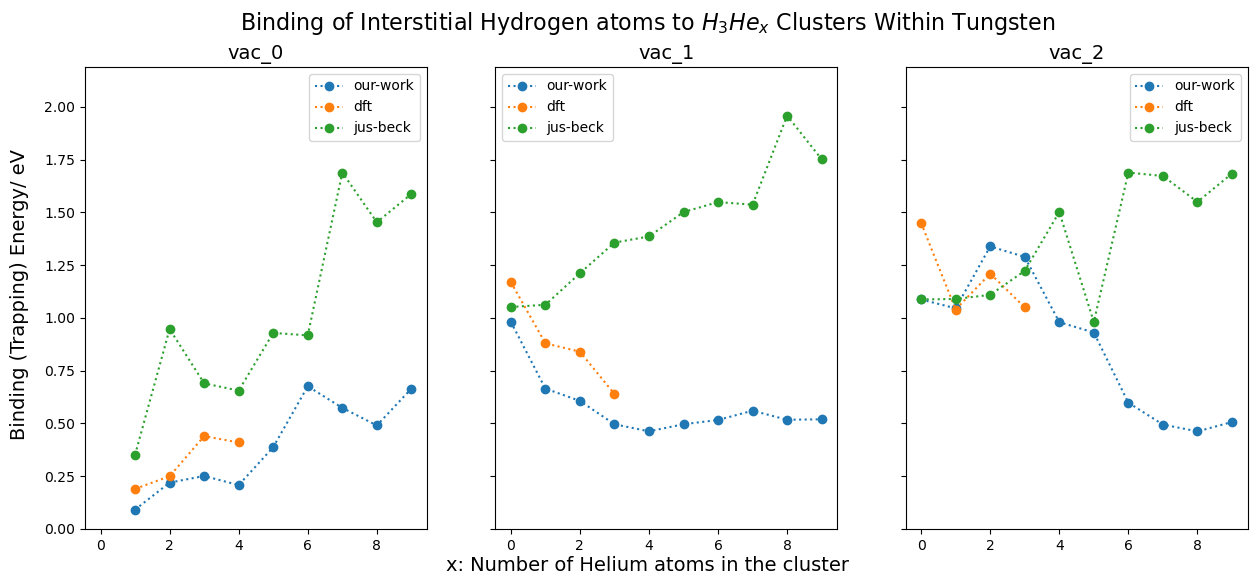

In [16]:
eam_he_self = find_h_he_binding(eam_data, key, 3)
dft_he_self = find_h_he_binding(dft_data, key, 3)
bonny_he_self = find_h_he_binding(jus_beck, key, 3)
new_he_self = find_h_he_binding(new_pot, key,  3)

# Convert each dictionary into a DataFrame
h_h3he_self = pd.DataFrame({'our-work':eam_he_self, 'dft':dft_he_self, 'jus-beck':bonny_he_self})

plot_data_binding(h_h3he_self,'Binding of Interstitial Hydrogen atoms to $H_3He_x$ Clusters Within Tungsten', 'x: Number of Helium atoms in the cluster')

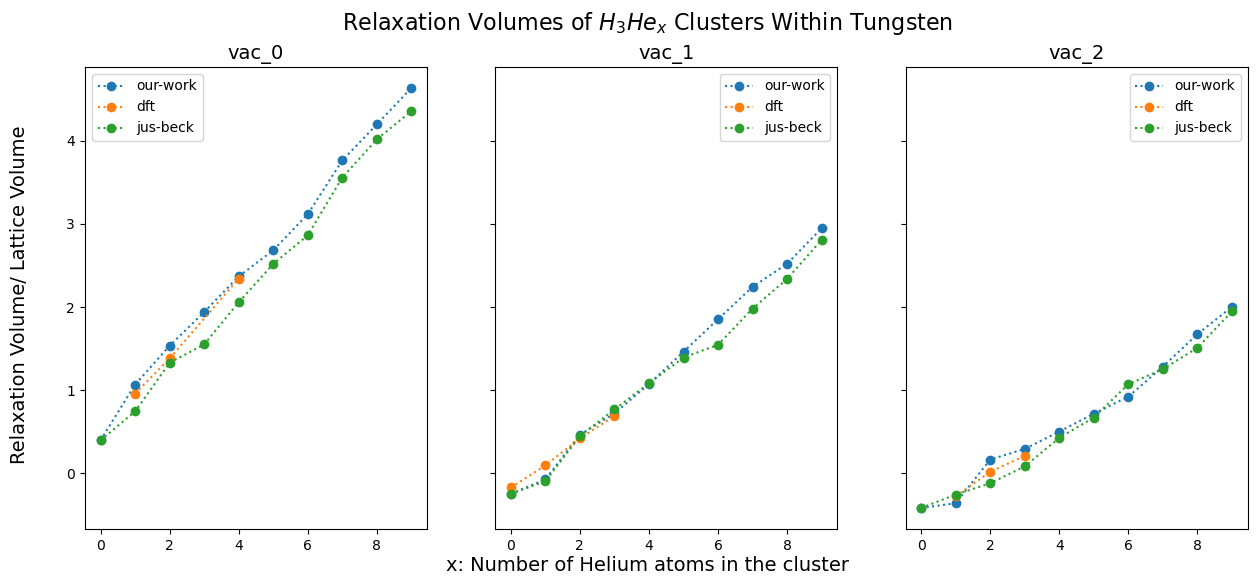

In [17]:
plot_data_rvol(h_h3he_self,'Relaxation Volumes of $H_3He_x$ Clusters Within Tungsten', 'x: Number of Helium atoms in the cluster')

ValueError: zero-size array to reduction operation maximum which has no identity

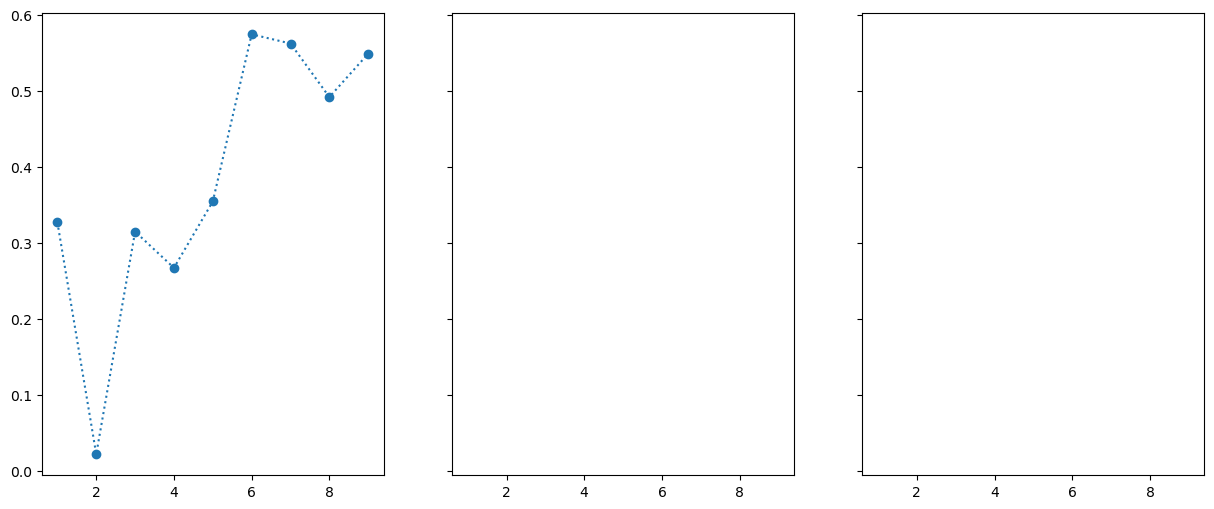

In [18]:
eam_he_self = find_h_he_binding(eam_data, key, 4)
dft_he_self = find_h_he_binding(dft_data, key, 4)
bonny_he_self = find_h_he_binding(jus_beck, key, 4)
new_he_self = find_h_he_binding(new_pot, key,  4)

# Convert each dictionary into a DataFrame
h_h3he_self = pd.DataFrame({'our-work':eam_he_self, 'dft':dft_he_self, 'jus-beck':bonny_he_self})

plot_data_binding(h_h3he_self,'Binding of Interstitial Hydrogen atoms to $H_3He_x$ Clusters Within Tungsten', 'x: Number of Helium atoms in the cluster')

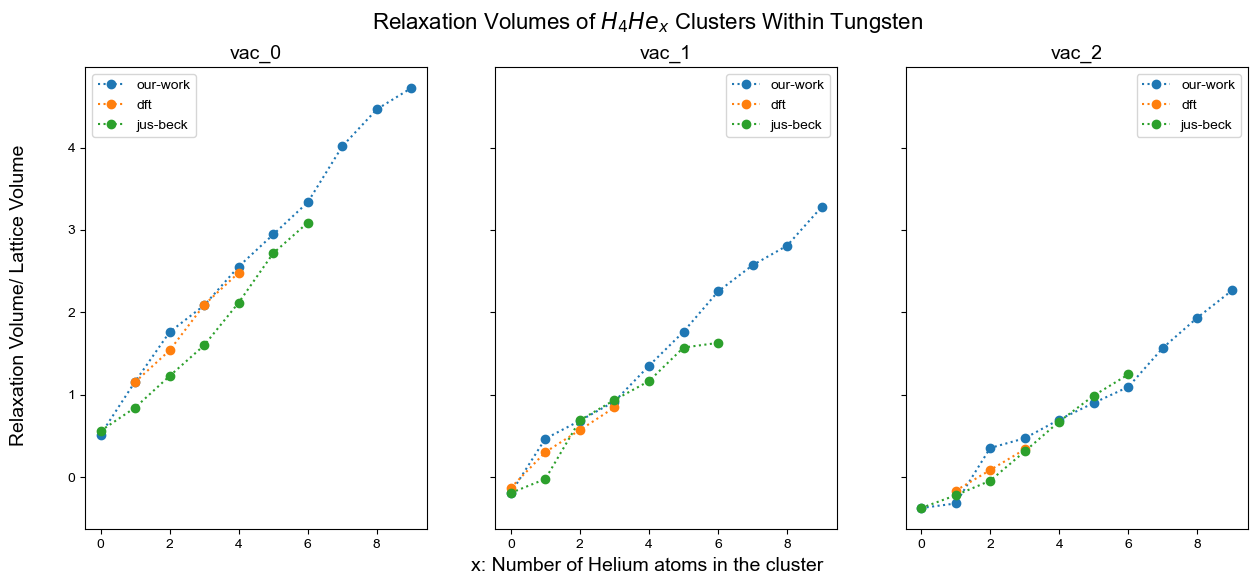

In [ ]:
plot_data_rvol(h_h3he_self,'Relaxation Volumes of $H_4He_x$ Clusters Within Tungsten', 'x: Number of Helium atoms in the cluster')

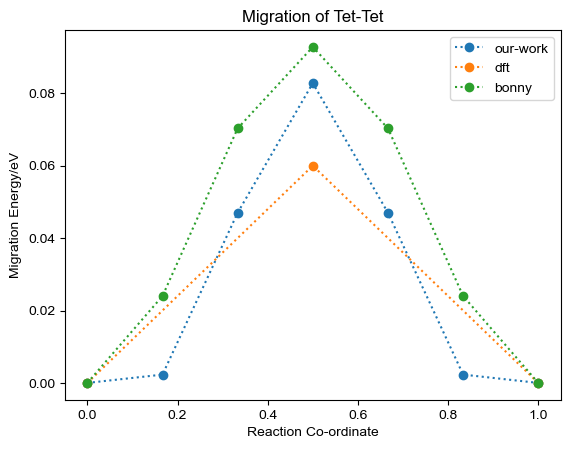

In [ ]:
data = '0              -6133.2398     0.16666666     -6133.2375     0.33333329     -6133.1928     0.49999989     -6133.157      0.66666663     -6133.1928     0.83333333     -6133.2375     1              -6133.2398'   

neb = np.array([float(string) for string in data.split(' ') if len(string) > 0]).reshape(7,2)

neb[:,1] -= neb[0,1]

data = '0              -6099.7155     0.16666664     -6099.6915     0.33333329     -6099.6452     0.49999998     -6099.6227     0.66666658     -6099.6452     0.83333326     -6099.6915     1              -6099.7155     '

neb_bonny = np.array([float(string) for string in data.split(' ') if len(string) > 0]).reshape(7,2)

neb_bonny[:,1] -= neb_bonny[0,1]

plt.plot(neb[:,0], neb[:,1], marker='o', linestyle=':', label='our-work', color=colors[0])
plt.plot([0, 0.5, 1], [0, 0.06,0], marker='o', linestyle=':', label='dft', color=colors[1]) 
plt.plot(neb_bonny[:,0], neb_bonny[:,1], marker='o', linestyle=':', label='bonny', color=colors[2])

plt.xlabel('Reaction Co-ordinate')
plt.ylabel('Migration Energy/eV')
plt.title('Migration of Tet-Tet')
plt.legend()

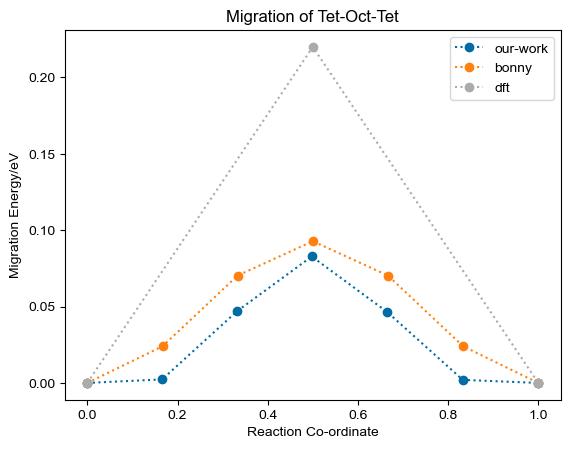

In [ ]:
data =  '0              -6133.2398     0.16588359     -6133.2375     0.33176715     -6133.1929     0.49765069     -6133.157      0.66510049     -6133.1934     0.83255026     -6133.2378     1              -6133.2398'    

neb = np.array([float(string) for string in data.split(' ') if len(string) > 0]).reshape(7,2)

neb[:,1] -= neb[0,1]

data = '0              -6099.7155     0.16666664     -6099.6915     0.33333329     -6099.6452     0.49999998     -6099.6227     0.66666658     -6099.6452     0.83333326     -6099.6915     1              -6099.7155     '

neb_bonny = np.array([float(string) for string in data.split(' ') if len(string) > 0]).reshape(7,2)

neb_bonny[:,1] -= neb_bonny[0,1]

plt.plot(neb[:,0], neb[:,1], marker='o', linestyle=':', label='our-work')
plt.plot(neb_bonny[:,0], neb_bonny[:,1], marker='o', linestyle=':', label='bonny')
plt.plot([0, 0.5, 1], [0, 6.38-6.16,0], marker='o', linestyle=':', label='dft') 

plt.xlabel('Reaction Co-ordinate')
plt.ylabel('Migration Energy/eV')
plt.title('Migration of Tet-Oct-Tet')
plt.legend()

Text(0.5, 1.0, 'Binding of a Hydrogen Atom to a Vacancy Helium Cluster')

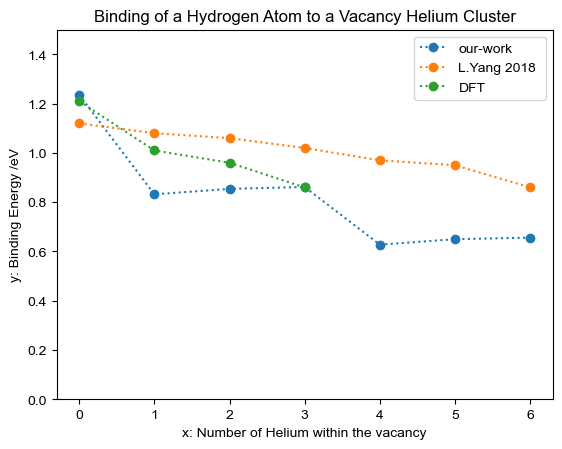

In [ ]:
y = np.array([1.23584632, 0.83191409, 0.85409194, 0.8617299 , 0.6277225 ,
       0.64985119, 0.65624434])

y2 = np.array([1.12, 1.08, 1.06, 1.02, 0.97, 0.95, 0.86])

y3 = np.array([1.21, 1.01, 0.96, 0.86])

plt.rcParams["font.family"] = "Arial"

plt.plot(np.arange(len(y)), y, label='our-work', linestyle=':', marker='o',color=colors[0])

plt.plot(np.arange(len(y2)), y2, label='L.Yang 2018 ', linestyle=':', marker='o',color=colors[1])

plt.plot(np.arange(len(y3)), y3, label='DFT', linestyle=':', marker='o',color=colors[2])

plt.legend()

plt.ylim(0, 1.5)

plt.ylabel('y: Binding Energy /eV')

plt.xlabel('x: Number of Helium within the vacancy')

plt.title('Binding of a Hydrogen Atom to a Vacancy Helium Cluster')